# Fully Connected Neural Networks

<font color="green"> 
In this notebook, we will implement a Neural Network (NN) from scratch and apply it to classification tasks. The main objectives are:
1. Implementing gradient descent (GD) and stochastic gradient descent (SGD) from scratch.
2. Building a fully connected NN from scratch.
3. Building a fully connected NN using PyTorch APIs.


</font>

<font color="green"> 
Complete the exercises marked with "Exercise". Fill in the code blanks marked with "TODO".

Do NOT change the cells marked with "TEST" -- they are for testing your completed code.
</font>

<font color="red"> 
Updates and corrected typos (15/02/2023):
1. "Synthetic Linear Regression Dataset": In the definition of the linear model, the noise variance is changed from $1$ to $0.1^2$, as the latter is what the code actually does.
2. `LinearModel`: In the `__init__` method, added `self.n = n`. This allows `len(lm)` to output `n`. However this should not have affected any part of the notebook -- it would only be needed if we were to convert `lm` to PyTorch's [`DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) and **use it with PyTorch's neural network APIs**, which we did not do.
3. "Elements of a NN Classifier" further remarks: Added another comment to emphasise the evaluation metric and loss function that we will use.
4. "Elements of a NN Classifier" picture of the NN architecture: Updated to match Exercise 10. There should be no activation function between the flattening layer and hidden layer 1, and there should be an activation function between hidden layer 2 and the output layer.

</font>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

# Gradient Descent

In the first part of this notebook, we will implement gradient descent (GD) and stochastic gradient descent (SGD) from scratch. We will only focus on the parameter update of these algorithms and assume we are given an oracle that, given an input $x$ and a function $f$, returns the gradient of $f$ at $x$.

Such an oracle can be achieved via [Automatic Differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (auto-diff, or AD). In brief, auto-diff is a set of techniques to evaluate the derivative of a given function. The derivatives computed by auto-diff is **exact** (unlike methods such as *finite difference* which approximates the derivative of a function), and the computational cost is almost the same as the function evaluation itself (no more than a small constant factor).

We will use PyTorch for auto-diff. Details will follow later in this section.

**Remarks:**
- In this case, since the objective is simply the least-square loss for a linear model, we can actually derive its gradient with respect to $\beta$ **analytically** without resorting to auto-diff, as you have seen in Week 2's notebook. 
- We use auto-diff here nonetheless as a demonstration of how this tool could be used to compute gradients in the general case, where the gradient of the objectives might be extremely tedious to derive analytically, as will be the case for neural network losses in the next part of this notebook.

In [2]:
class Convergence2DPlotting(object):
  """ Plotting utils for visualizing optimization paths on 2D functions. """

  def __init__(self, f, x_star):
    self.f = f
    self.fig, self.ax = plt.subplots()
    self.fig.set_size_inches(8.0, 8.0)
    self.ax.set_aspect("equal")

    # mark the optimal parameter x_star on plot.
    self.ax.scatter(x_star[0], x_star[1], color="red", marker="x", zorder=10)

  def plot_iterates(self, iterates, color="C0"):
    iterates = torch.tensor(iterates).squeeze()
    x, y = iterates[:,0], iterates[:, 1]
    self.ax.scatter(x,y,s=0)
    for i in range(len(x)-1):
      self.ax.annotate(
        "", 
        xy=(x[i+1], y[i+1]), 
        xytext=(x[i], y[i]),
        arrowprops={"arrowstyle": "->", "color":  color, "lw": 2},
      )

  def plot_contours(self):
    x_min, x_max = self.ax.get_xlim()
    y_min, y_max = self.ax.get_ylim()

    # generate the contours of f on the above computed range.
    n_points = 50
    x = torch.linspace(start=x_min, end=x_max, steps=n_points)
    y = torch.linspace(start=y_min, end=y_max, steps=n_points)
    x, y = torch.meshgrid(x, y)
    z = torch.zeros_like(x)
    for x_idx in range(n_points):
      for y_idx in range(n_points):
        input = torch.tensor([x[x_idx, y_idx], y[x_idx, y_idx]]).reshape(2,)
        z[x_idx, y_idx] = self.f(input)
    self.ax.contour(x,y,z, colors="k")

## Synthetic Linear Regression Dataset

We will consider the **linear regression** problem. Given features $x_1, \ldots, x_n \in \mathbb{R}^d$ and responses $y_1, \ldots, y_n \in \mathbb{R}$ for which
$$
  y_i = x_i^\top \beta^* + \epsilon_i \;,
$$
where <font color="red"> $\epsilon_i \sim \mathcal{N}(0, 0.1^2)$ </font> i.i.d., and $\beta^* \in \mathbb{R}^d$ is the ground-truth parameter vector. **We aim to use GD/SGD to solve the least-square objective**
$$
  \hat{\beta}
  := \arg\min_{\beta \in \mathbb{R}^d} \sum_{i=1}^n (y_i - x_i^\top \beta)^2
  \;.
$$

We first define the MSE loss.

In [3]:
def mse(input, target):
  """
  Compute the MSE:
    MSE(\hat{y}, y) = \sum_{i=1}^n (\hat{y}_i - y_i)^2.

  Args:
    input: (n,) A tensor of predicted responses.
    Target: (n,) A tensor of true responses. 
  
  Returns:
    res: The MSE loss.
  """
  res = torch.mean((input - target)**2)
  return res

We then define a class that generates synthetic data according to the linear regression model described above. Note that the `eval_and_compute_loss` method is the function that we will minimize.

In [4]:
class LinearModel(object):
  """
  Generates a linear regression dataset.
  """

  def __init__(self, n, d, seed: int=0):
    # set seed for reproducibility
    torch.manual_seed(seed)

    # 1. generate the covariates matrix.
    X = torch.normal(0, 1, size=(n, d)) # Identity covariance component.
    X /= torch.sqrt(torch.sum(X**2, axis=1)).reshape(-1,1) # Normalize rows of X.
    # 2. sample some ground truth parameter w*.
    w_star = torch.normal(0, 1, size=(d,))
    # 3. normalize the ground truth parameter to have norm 5 (for 2d plots).
    w_star /= torch.sqrt(torch.sum(w_star**2)) / 5.0
    # 4. generate observations.
    y = self.eval(X, w_star) + 0.1 * torch.normal(0, 1, size=(n,))
    
    self.X = X              # features
    self.y = y              # responses
    self.w_star = w_star    # true parameters
    self.n = n              # number of data points

  def __getitem__(self, index):
    return self.X[index], self.y[index]
  
  def __len__(self):
    return self.n

  def eval(self, X, w):
    """
    Evaluate the linear model given feature matrix X and parameters w.

    Args:
      X: (n, d) A feature matrix where each row is a feature vector.
      w: (d,) A vector of parameters.

    Returns:
      (d,) A vector where the i-th entry is x_i^T w.
    """
    return torch.matmul(X, w)

  def eval_and_compute_loss(self, params):
    """
    Evaluate the linear model given parameters w, and compute the loss. 

    Args:
      X: (n, d) A feature matrix where each row is a feature vector.
      w: (d,) A vector of parameters.

    Returns:
      MSE(Xw, y)
    """
    preds = self.eval(self.X, params)
    loss = mse(preds, self.y)
    return loss

We generate 100 data points with dimension 2.

In [5]:
lm = LinearModel(100, 2)

In [6]:
print("X:", lm.X.shape, "y:", lm.y.shape)

X: torch.Size([100, 2]) y: torch.Size([100])


Expected output:
```python
X: torch.Size([100, 2]) y: torch.Size([100])
```

## Gradient Descent
Recall that the GD algorithm proceeds as follows: Given a differentiable function $f: \mathbb{R}^d \to \mathbb{R}$, some starting point $\beta_0 \in \mathbb{R}^d$, and step-sizes $\epsilon_t > 0$,
1. For $t = 1, 2, 3, \ldots, $
  - $\beta_t = \beta_{t - 1} - \epsilon_t \nabla f(\beta_{t-1})$.

For simplicity, we will use a **fixed** step-size $\epsilon_t \equiv \epsilon$ for some $\epsilon > 0$, although it is not difficult to generalise to the variable step-sizes case.

We will subclass the [`torch.optim.Optimizer`](https://pytorch.org/docs/stable/optim.html) module. This is a built-in module from PyTorch that allows custom optimisation algorithm to be implemented in a way that is compatible with the PyTorch synmantics. At its core are the following two attributes:
1. `parameters`: Variables to be optimised with respect to. It has to be an **iterable (e.g., list)** of `torch.tensor` that **requires gradient computation**.
2. `defaults`: A dictionary of any hyper-parameters for the optimisation algorithm.

The parameters and hyper-parameters are accessible from the class attribute `param_groups`, which is a **list of parameter groups**, each being a **dictionary** with keys 
- `params` (for the parameters), and 
- the keys of any hyper-parameters in `defaults`. 

In our example, we will always have **a single parameter group**, although for the general case one might want to have more than one parameter group (e.g., one for each layer of a neural network, each with a different learning rate).

#### Exercise 1
Implement the Gradient Descent algorithm. In the `step` method,

1. Get the gradient evaluate at the parameters by `params.grad.data`.
2. Call [`params.data.add_`](https://pytorch.org/docs/stable/generated/torch.Tensor.add_.html) to update the parameters. You should provide the appropriate inputs to the fuction `_add` (remember that we wish to **minimise** a function).

  <details><summary>Hint 1</summary>
  <p>

  Given tensors `x`, `y` and `epsilon`, the call `x._add(y, epsilon)` computes `x + epsilon*y`.

  </p>
  </details>

  <details><summary>Hint 2</summary>
  <p>

  `_add` is an **in-place** operation, meaning that it modifies a given tensor directly without making a copy, so in particular no value is returned. 

  </p>
  </details>

In the `optimize` method, 
3. By studying the example in the [official documentation](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step), take a single optimisation step.


In [7]:
class GD(torch.optim.Optimizer):
  def __init__(self, parameters, lr: float=1e-3):
    defaults = {"lr": lr}                  # set hyper-param for GD 
    super().__init__(parameters, defaults) # pass args to parent class

  def step(self, closure=None):
    """
    Performs a single optimisation step.
    """
    param_group = self.param_groups[0]
    params_list = param_group["params"]

    # loop through all parameters in the first parameter group
    for params in params_list:
      ### TODO ###
      # 1. get gradient
      grad = params.grad.data
      # 2. update gradient
      params.data.add_(grad, alpha=-param_group["lr"])
      ### END OF TODO ###

  def optimize(self, f, niterations):
    """
    Performs the Gradient Descent algorithm to find the 
    minimiser to f.

    Args:
      f: A function to be minimised.
      niterations: Number of times to perform the optimisation algorithm.

    Returns:
      iterates: A list of w values at every iteration.
    """
    w = self.param_groups[0]["params"][0]

    iterates = []
    iterates.append(w.clone().detach().numpy().reshape(-1, 1))
    for _ in range(niterations):
      ### TODO ###
      # 3.1. reset gradients to zero 
      self.zero_grad()
      # 3.2. compute loss
      loss = f(w)
      # 3.3. compute gradient
      loss.backward()
      # 3.4. update parameters
      self.step()
      ### END OF TODO ###

      # log intermediate values
      iterates.append(w.clone().detach().numpy().reshape(-1, 1))

    return iterates

**Auto-diff using PyTorch:**

Note how we used PyTorch semantics to compute the gradient and update the parameters:
1. `zero_grad()` clears any gradient values previously stored in the optimizer to 0.
2. We then evaluate the function (loss). Any operations here will be logged for gradient computation later.
3. `backward()` computes the gradient using auto-diff. The "backward" refers to the algorithm used for computing the gradient, i.e., [back-propagation](https://en.wikipedia.org/wiki/Backpropagation).
4. `step()` performs a single optimisation step, in this case one GD update.

Also note that the method `optimize` is merely a utility function for our exercise and is not required when building a custom optimiser with PyTorch --- only the `__init__` and `step` methods are always necessary. 

We now initialise the optimiser and a starting point and perform GD to find the minimum. Note that when initiating `w`, we must set `requires_grad=True` to ask PyTorch log any operations performed with `w`. Otherwise no gradient information will be stored. 

In [8]:
w = torch.tensor([1., 1.], requires_grad=True)  # initial point
optimizer = GD([w], lr=0.1)                     # optimiser

iterates_gd = optimizer.optimize(
    f=lm.eval_and_compute_loss,
    niterations=50,
)

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_76832/881954044.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  iterates = torch.tensor(iterates).squeeze()
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


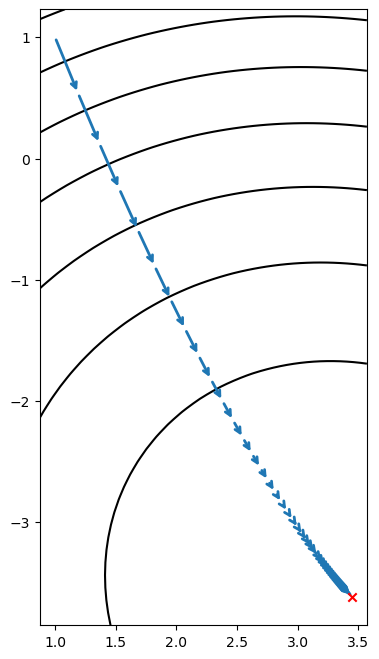

In [9]:
gd_plotting = Convergence2DPlotting(
    f=lm.eval_and_compute_loss, x_star=lm.w_star,
)
gd_plotting.plot_iterates(iterates_gd)
gd_plotting.plot_contours()

#### Exercise 2
Fix `niterations` and vary the learning rate in the GD optimiser, and comment on your observations.

<details><summary>Solution</summary>
<p>

When the learning rate is overly small (e.g., 0.01), each update will be tiny and it will require a large number of steps to converge.

When the learning rate is large (e.g., 1.5), it might take fewer steps to reach to a region near the minimum, but it will then fluctuate around the minimum. 

An even larger learning rate (e.g., 2) can even causes divergence. 

**Bonus:** One can mathematically prove the number of GD steps needed to reach a given precision (see, e.g., Chapter 9.3.1 of [4]). Such analysis is called the **convergence analysis** of an optimisation algorithm.

</p>
</details>


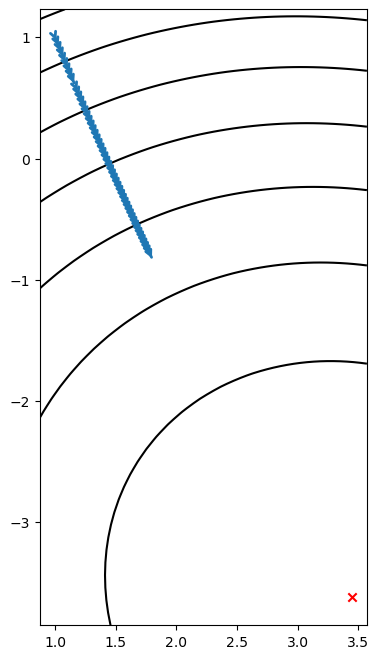

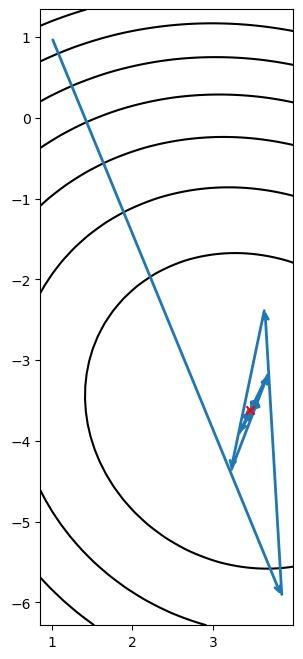

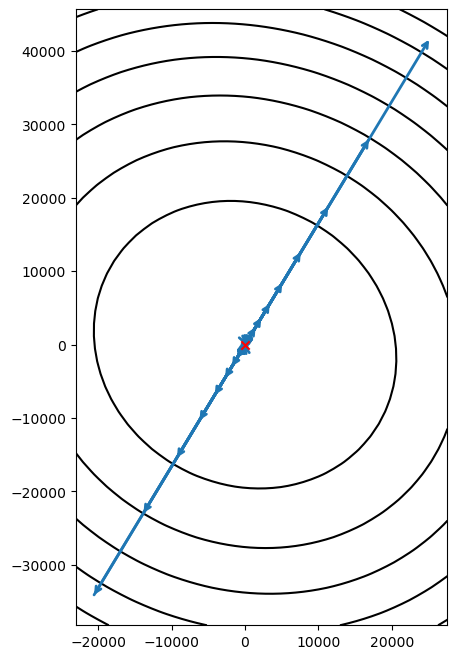

In [10]:
for lr in [0.01, 1.5, 2.]:
  w = torch.tensor([1., 1.], requires_grad=True)  # initial point
  optimizer = GD([w], lr=lr)                      # optimiser

  iterates_gd2 = optimizer.optimize(
      f=lm.eval_and_compute_loss,
      niterations=50,
  )

  gd_plotting = Convergence2DPlotting(
      f=lm.eval_and_compute_loss, x_star=lm.w_star,
  )
  gd_plotting.plot_iterates(iterates_gd2)
  gd_plotting.plot_contours()

## Stochastic Gradient Descent

Often in machine learning the function $f$ that we wish to be minimised has the decomposition
$$
  f(\beta) = \sum_{i=1}^n f_i(\beta) \;,
$$
for some functions $f_i$. Examples include
- MSE: $l(\hat{y}, y) = \sum_{i=1}^n (\hat{y}_i - y_i)^2$.
- Negative log-likelihood: $l(x) = - \sum_{i=1}^n \log p(x_i)$, where $p$ is a probability density function.

In this case, if a single evaluation of $f$ is computationally costly (e.g., when $n$ is too large), then minimising $f$ via GD would become prohibitive, as GD usually requires evaluating $f$ by a large amount of times.

Stochastic Gradient Descent (SGD) serves as a computationally cheap alternative in this cas|e. Given an initial point $x_0$, SGD proceeds as:
1. For $t = 1, 2, \ldots, T$,
  1. Randomly permute data points $1, \ldots, n$.
  2. For $i = 1, 2, \ldots, n$:
    - $\beta_t = \beta_{t-1} - \epsilon_t \nabla f_i(\beta_{t-1})$.

The intuition behind using $\nabla f_i(\beta_{t-1})$ to update the parameter is that it can be seen as a **Monte Carlo estimate** of the "true" gradient $\nabla f(\beta) = \sum_{i=1}^n \nabla f_i(\beta)$ using a single Monte Carlo sample. 

"Stochastic" refers to the stochasticity in the radom permutation at each iteration. Compared with GD, the inner loop uses the gradient evaluated with **a single data point** to update the parameters. This means $T$ can be chosen to be relatively small to reduce the computationally burden.

In machine learning terminologies, each outer loop (one iteration over the full dataset) is known as an **epoch**, and $T$ is called the **number of epochs**.


**Data loaders**
To implement the SGD algorithm, we need to evaluate the objective function at every data point. To do so, we use [`torch.utils.data.DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), a tool that is able to partition a given dataset into subsets of a given size (called **batch size**).

The input to dataloader can be of different types. One option is to provide a list where each element is a $(x_i, y_i)$ tuple.

We also set `batch_size=1`, so that each time the dataloader returns a single pair of feature and response.

In [11]:
data_sgd = torch.utils.data.DataLoader(
  dataset=[(lm.X[i], lm.y[i]) for i in range(lm.X.shape[0])], 
  batch_size=1,
)

In [12]:
next(iter(data_sgd))

[tensor([[-0.6988, -0.7153]]), tensor([0.1230])]

Expected output:
```python
[tensor([[-0.6988, -0.7153]]), tensor([0.1230])]

```

#### Exercise 3

Implement the SGD algorithm by completing the `optimize` method below.
1. Compute the model predictions using `model_eval`.
2. Compute the loss using the loss function `loss_fn`.
3. Back-propagate to update the parameters.

In [13]:
class SGD(GD):
  def __init__(self, parameters, lr: float=1e-3):
    super().__init__(parameters, lr)

  def optimize(self, model_eval, loss_fn, niterations, data):
    """
    Performs the Gradient Descent algorithm to find the 
    minimiser to f.

    Args:
      f: A function to be minimised.
      niterations: Number of times to perform the optimisation algorithm.

    Returns:
      iterates: A list of w values at every iteration.
    """
    w = self.param_groups[0]["params"][0]

    iterates = []
    iterates.append(w.clone().detach().numpy().reshape(-1, 1))
    for _ in range(niterations):
      for X, y in data:
        self.zero_grad()
        ### TODO ###
        # compute model predictions
        preds = model_eval(X, w)
        # compute loss
        loss = loss_fn(preds, y)
        # back-propagate and update parameters
        loss.backward()
        self.step()
        ### END OF TODO ###

        iterates.append(w.clone().detach().numpy().reshape(-1, 1))

    return iterates

In [14]:
w = torch.tensor([1., 1.], requires_grad=True)
optimizer = SGD([w], lr=0.1)

iterates_sgd = optimizer.optimize(
  model_eval=lm.eval,
  loss_fn=mse,
  niterations=5,
  data=data_sgd,
)

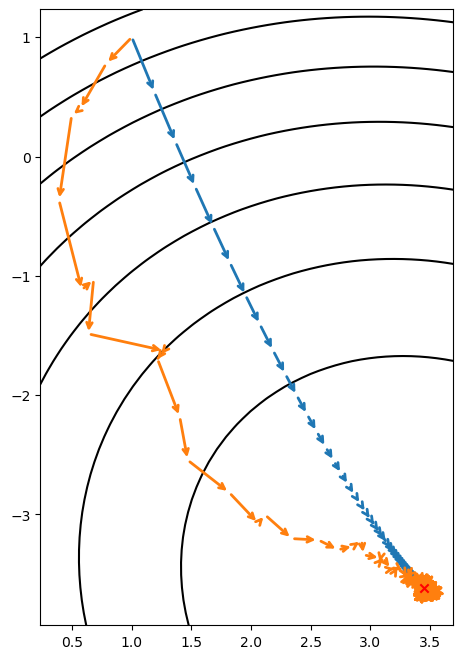

In [15]:
gd_plotting = Convergence2DPlotting(
    f=lm.eval_and_compute_loss, x_star=lm.w_star,
)
gd_plotting.plot_iterates(iterates_gd)
gd_plotting.plot_iterates(iterates_sgd, color="C1")
gd_plotting.plot_contours()

#### Exercise 4
Comment on how the trace plot of SGD compares with that of GD.

<details><summary>Solution</summary>
<p>
  The trace plot of SGD is more noisy compared with that of GD. This is because each update step of SGD uses an estimate of the gradient, whereas GD uses the true gradient, which is the direction of **steepest descent**. As a result, SGD can take more iterations to converge, and the path fluctuates around the minimum. 

  **Bonus**: This noisy behaviour can sometimes be desirable, as it may help the optimisation algorithm to escape possible **local** minima of the objective function.
</p>
</details>

## Minibatch Gradient Descent

SGD uses a single data point as an estimate of the gradient descent to save computational cost. However, estimates based on a single data point might be too crude, which would result in a slow convergence.

The **Minibatch Gradient Descent** serves as a "middle ground" between GD and SGD, where $m$ data points ($1 \leq m \leq n$) are used at each step to estimate the gradient. It proceeds as follows:
1. For $t = 1, 2, \ldots, T$,
  1. Randomly permute data points $1, \ldots, n$.
  2. For $j = 1, 2, \ldots, \lfloor n/m \rfloor$:
    - $\beta_t = \beta_{t-1} - \frac{\epsilon_t}{m} \sum_{i=1 + m(j-1)}^{\max(1+mj, n)} \nabla f_i(\beta_{t-1})$.

The batch size $m$ trades-off the computational cost and convergence rate:
1. The larget the batch size, the faster the convergence rate due to more accurate gradient estimation, but the computational cost would be higher. It reduces to GD when $m = n$.
2. The smaller the batch size, the more computational (and memory) efficient, but the convergence would be slower. It reduces to SGD when $m = 1$.

There is no best choice of $m$. As a rule of thumb, it is often chosen to be **multiples of 2** (32, 64, 128, 256, 512) for programming efficiency reasons when working with CPUs/GPUs.



We can use our `SGD` class to perform mini-batch GD by simply providing a dataloader that has `batch_size` greater than 1.

In [16]:
data_mbgd = torch.utils.data.DataLoader(
  dataset=[(lm.X[i], lm.y[i]) for i in range(lm.X.shape[0])], 
  batch_size=5,
)
niterations = 10

w = torch.tensor([1., 1.], requires_grad=True)
optimizer = SGD([w], lr=0.1)
iterates_mbgd = optimizer.optimize(
  model_eval=lm.eval,
  loss_fn=mse,
  niterations=niterations,
  data=data_mbgd,
)

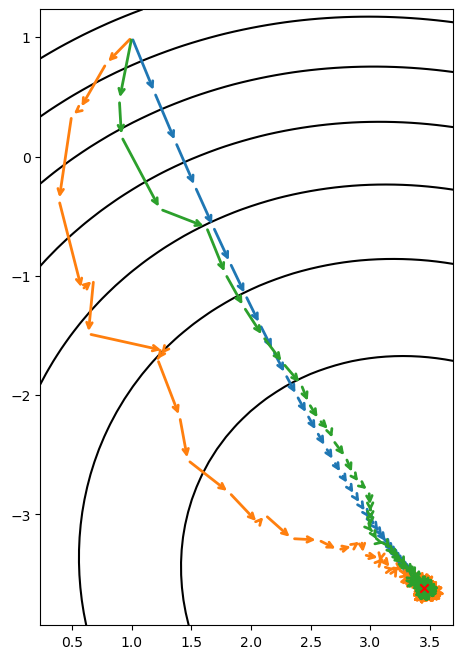

In [17]:
gd_plotting = Convergence2DPlotting(
    f=lm.eval_and_compute_loss, x_star=lm.w_star,
)
gd_plotting.plot_iterates(iterates_gd)
gd_plotting.plot_iterates(iterates_sgd, color="C1")
gd_plotting.plot_iterates(iterates_mbgd, color="C2")
gd_plotting.plot_contours()

# Fully Connected Neural Networks from Scratch

We will first build a feedforward NN without using the layer classes from `torch.nn`, and use it to classify images of clothes.


## Fashion-MNIST Data

The [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset contains images of clothes, where each example is a $28 \times 28$ grayscale image that is associated with one of 10 possible labels. It is divided into a training set of 60,000 examples and a test set of 10,000 examples, where each class has an equal number of training and testing examples. Fashin-MNIST is often used as a more difficult alternative to the celebrated [MNIST](http://yann.lecun.com/exdb/mnist/).

In [18]:
# set seed for reproducibility
SEED = 2023
np.random.seed(SEED)
torch.manual_seed(SEED)

We can load the Fashion-MNIST dataset from the [`torchvision.datasets`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) API.

In [19]:
# download data
train_set = torchvision.datasets.FashionMNIST(
  root="./", 
  download=True, 
  train=True,
  transform=transforms.Compose([transforms.ToTensor()]),
)

test_set = torchvision.datasets.FashionMNIST(
  root="./", 
  download=True, 
  train=False,
  transform=transforms.Compose([transforms.ToTensor()]),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

: 

: 

We will only use a subset of the dataset that belong to certain classes. This is only to avoid an overly long training time.

In [ ]:
def preprocess(data, classes=[0, 1, 2]):
  """
  Extracting only a subset of examples belonging
  to certain classes.
  """
  data = [d for d in data if d[1] in classes]
  return data

# keep only data with class labels in 0, 1, 2
train_set = preprocess(train_set)
test_set = preprocess(test_set)

We now visualise some examples using `matplotlib.pyplot.imshow`. The labels are encoded as numerics $0, 1, 2, \ldots, 9$. We rename them in the plot to the corresponding clothing types.

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

def visualise(data, cols=3, rows=3):
  """
  Utility function for plotting images with labels.
  """
  fig = plt.figure(figsize=(8, 8))
  for i in range(cols * rows):
      img, label = data[i]
      fig.add_subplot(rows, cols, i+1)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  
  plt.tight_layout()
  plt.show()

def visualise_pred(data, model, cols=3, rows=3):
  """
  Utility function for plotting images with true
  and predicted labels.
  """
  fig = plt.figure(figsize=(8, 8))
  for i in range(cols * rows):
    img, label = data[i]
    
    # true label
    label_text = labels_map[label]

    # predicted label
    pred_probs = model(img)
    pred_label = torch.argmax(pred_probs, dim=-1).item()
    pred_label_text = labels_map[pred_label]

    # different colors for wrong/correct predictions
    color = "green" if pred_label_text == label_text else "red"

    # show image
    fig.add_subplot(rows, cols, i+1)
    plt.title(f"True: {label_text}\nPred: {pred_label_text}", color=color)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  
  plt.tight_layout()
  plt.show()

In [ ]:
subset = [train_set[i] for i in torch.randint(len(train_set), size=(9,))]
visualise(subset)

We will use mini-batch training. The `torch.utils.data.DataLoader` is a helpful tool for partitioning our training dataset to mini-batches.

In [ ]:
# use data loader
train_set = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

## Elements of a NN Classifier

The NN model that we will build will have the following architecture:
<figure class="image">
  <img src="https://drive.google.com/uc?export=view&id=1dGrZ1F_4_j6fxk5_TVoe7IUylENWb8pa" alt="{{ include.description }}" width="500">
</figure>

In words, an input data will be passed through:
1. **Flatten layer**: A layer that reshapes the input to a vector in $784$ dim.
2. **Hidden layer 1**: A fully connected linear layer with 256 nodes, followed by a ReLU activation function.
3. **Hidden layer 2**: A second fully connected linear layer with 256 nodes, followed by a ReLU activation function.
4. **Output layer**: A fully connected linear layer (with on activations).

**Remarks:**
- Since the data input has shape `(28, 28)`, we first **flatten** it into a column vector of dimension $28 \times 28 = 784$.
- The two hidden layers are fully connected linear layers.
- The output from each hidden layer is passsed through a **ReLU activation function**. 
- The output will be a column vector $x_\textrm{out}$ of dimension equal to the number of classes in the data. We will use $x_\textrm{out}$ to model the **log predicted probability**, so each entry in $x_\textrm{out}$ can in general take values in $\mathbb{R}$. An alternative approach is to model instead the **predicted probability** by using an extra transformation (e.g., softmax) to enforce the output vector has non-negative entries that sum to 1.




**Further remarks:**
- <font color="red">We will use the cross entropy function for model training and the accuracy function for model evaluation. </font>
- Accuracy might not be a suitable evaluation metric if the data is **imbalanced**, meaning that the number of data points belonging to one class is vastly different from the others. However, since for Fashion-MNIST there is an equal number of examples in each class, this is not an issue.

**To summarise, we will need the following:**
1. A fully connected linear layer, akin to [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).
2. A ReLU activation function, akin to [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).
3. [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function for model training.
4. [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) for model evaluation.

### Fully Connected Layers

We will define a `Linear` layer class that inherits from the `torch.nn.Module` class from PyTorch. This allows us to build custom layer classes that can be used similarly as the built-in layer classes from `torch.nn`, so that we can leverage PyTorch's auto-differentiation to train our model.

From the documentation of [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), there are several elements that we need to specify:
- `in_features`: shape of input,
- `out_features`: shape of output,
- `bias`: whether or not to include the bias term.

The linear layer will then initialise a weight matrix and a bias vector of appropriate shapes, so that, when given an input of shape `(n, in_features)`, it returns an output of shape `(n, out_features)`.

We will initialise these parameters from a standard Gaussian distribution. Initialisation of NN parameters can have significant impact on the model performance and convergence [1], and other initialisation strategies with better empirical performance exist (e.g., Kaiming initialisation [2], Xavier initialisation [3]). We do not dive deep into this topic in this notebook.

Also, the class needs to hold the weights and bias as [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) so that it can be trained using auto-differentiation.

#### Exercise 5
Complete the `Linear` class below. In the `__init__` method,
1. Initialise the weights and bias terms with **appropriate shapes**, where each entry is drawn independently from a **standard Gaussian distribution**. 
  - **Bonus:** If you feel ambitious, implement the [Kaiming uniform](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialisation explained in the link. This is the initialisation used in `torch.nn.Linear`.
2. Pass (separately) the weights and bias into `torch.nn.Parameter`. This will register them as model parameters, which is needed for the backpropagation later on.
3. Set the weights and bias as attributes of the class.

In the `forward` method,
4. Complete the operation by multiplying the input with the weigt matrix, and adding the bias term to the product.

In [ ]:
class Linear(nn.Module):
  def __init__(self, in_features, out_features, bias=True):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.bias = bias

    # initialise weights and biases
    self.weight = torch.nn.Parameter(torch.randn(out_features, in_features))
    self.bias = torch.nn.Parameter(torch.randn(out_features))

  def forward(self, input):
    """
    Args:
      input: (n, d_in)

    Returns:
      output: (n, d_out)
    """
    dim = input.shape[-1]
    if dim != self.in_features:
      raise RuntimeError(f"Wrong input feature shape. Expect {self.in_features} but received {dim}.")

    output = torch.matmul(input, torch.transpose(self.weight, -1, -2)) + self.bias

    return output

In [1]:
### TEST ###
_linear = Linear(in_features=3, out_features=8)
_xx = torch.randn((10, 3))
_linear(_xx), _linear(_xx).shape
### END OF TEST ###

NameError: name 'Linear' is not defined

#### Exercise 6
Complete the `ReLU` class below.
1. Given an input $x$, it computes **component-wise** $\textrm{ReLU}(x) = \max(0, x)$.
2. You will find the [`torch.clamp`](https://pytorch.org/docs/stable/generated/torch.clamp.html) function helpful.


In [ ]:
class ReLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input):
    """
    Apply component-wise the ReLU function to the input.
    """
    ### TODO ###
    output = torch.clamp(input, min=0.)
    ### END OF TODO ###
 
    return output

In [ ]:
### TEST ###
_x = torch.tensor([0.5, 0., -0.5])
_y1 = ReLU()(_x)
_y2 = nn.ReLU()(_x)
assert torch.allclose(_y1, _y2), "ReLU implementation does not match built-in function"
### END OF TEST ###

Finally, we define a flatten layer that converts a rank-2 tensor to a rank-1 tensor.

#### Exercise 7
Complete the class below. Given an input of rank 2, the `forward` method should output the input tensor reshaped to rank 1 (i.e., a vector).

In [ ]:
class Flatten(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input):
    """
    Args:
      input: (..., d1, d2) A tensor of arbitrary shape.

    Returns:
      output: The input tensor reshaped to rank 1.
    """
    n = input.shape[0]
    output = torch.reshape(input, shape=(n, -1))
 
    return output

In [ ]:
### TEST ###
_x = torch.tensor([[1., 2.], [3., 4.], [5., 6.]])
_y1 = Flatten()(_x)
_y2 = nn.Flatten()(_x)
assert torch.allclose(_y1, _y2), "Flatten implementation does not match built-in funciton."
### END OF TEST ###

### Loss Function
We will train the model using the [**cross-entropy loss**](https://en.wikipedia.org/wiki/Cross_entropy). Given a class label $y \in \mathcal{C}$ where $\mathcal{C}$ denotes the set of class labels, and given $x_\textrm{out} \in \mathbb{R}^{|\mathcal{C}|}$, we define 
\begin{align}
  l(x_\textrm{out}, y)
  = - \log \frac{ \exp\left( x^{(y)}_\textrm{out} \right) }{\sum_{c \in \mathcal{C}} \exp\left( x^{(c)}_\textrm{out} \right)} 
  \;,
  \tag{1}
\end{align}
where $x^{(c)}_\textrm{out}$ denotes the **$c$-th component** of $x_\textrm{out}$ (**not** the $c$-th power). The **cross-entropy loss** is defined as the sum over all data points:
\begin{align}
  \mathcal{L}(\mathbf{X}, \mathbf{y})
  := \sum_{i = 1}^N l(f(x_i), y) \;,
  \tag{2}
\end{align}
where $f: \mathbb{R}^d \to \mathbb{R}^{|\mathcal{C}|}$ denotes the NN model, and $\mathbf{X} := \{ x_i \}_{i=1}^N$ and $\mathbf{y} = \{ y_i \}_{i=1}^N$ denote the features and labels of the training data, respectively.


#### Exercise 8
Complete the function below that computes the cross-entropy loss. It should 
1. Take as its input:
  1. `input`: a tensor of shape `(n, nclass)`, where each row contains the predicted **log** probability for each class.
  2. `target`: a tensor of shape `(n,)`, where each entry contains the label.
2. Return the cross-entropy loss (2) **divided by $n$**.

**Remarks:** Your code should be numerically stable. You will find `torch.logsumexp` useful.

In [ ]:
def cross_entropy(input, target):
  """
  Args:
    input: (n, nclass) A tensor where the (i, j)-th entry contains the predicted 
      **log** probability that example i belongs to class j.
    target: (n,) A tensor the i-th each entry contains the label for example i.
  
  Returns:
    loss: The cross-entropy loss divided by n.
  """
  n = input.shape[0]
  
  ### TODO ###
  # compute log(softmax) for each class
  log_softmax = input - torch.logsumexp(input, dim=-1, keepdim=True) # n
  # extract log(softmax) for the true class
  log_softmax = log_softmax[torch.arange(0, n), target] # n
  # sum log(softmax) for all instances
  loss = - torch.sum(log_softmax) / n
  ### END OF TODO ###

  return loss


In [ ]:
### TEST ###
torch.manual_seed(SEED)
_x = torch.randn(3, 5)
_y = torch.randint(low=0, high=5, size=(3,))

_loss = nn.CrossEntropyLoss()
_output1 = _loss(_x, _y)
_output2 = cross_entropy(_x, _y)

assert torch.allclose(_output1, _output2), "Cross-entropy does not match built-in function"
### END OF TEST ###

### Evaluation Metric
Finally, we will evaluate the model using the accuracy metric:
$$
  \textrm{Accuracy}
  = \frac{1}{N} \sum_{i=1}^N 1{(y_i = \hat{y}_i)} \;,
$$
where $\hat{y}_i$ denotes the **predicted** label for the $i$-th example.

#### Exercise 9
Complete the function below that computes the accuracy metric.

In [ ]:
def accuracy(preds, target):
  """
  Args:
    preds: (n, nclass) A tensor where the (i, j)-th entry contains the predicted 
      **log** probability that example i belongs to class j.
    target: (n,) A tensor the i-th each entry contains the label for example i.
  
  Returns:
    acc: The accuracy metric.
  """
  ### TODO ###
  pred_labels = torch.argmax(preds, dim=-1)
  acc = torch.mean((pred_labels == target).to(preds.dtype))
  ### END OF TODO ###
  
  return acc

In [ ]:
### TEST ###
_preds = torch.tensor([[0.1, 0.2, 0.7], [0.8, 0.1, 0.1], [0.8, 0.1, 0.1], [0.2, 0.5, 0.3]])
_y = torch.tensor([0., 2., 0., 1.])
assert accuracy(_preds, _y) == 0.5, "Accuracy does not match built-in funciton"
### END OF TEST ###

## Build a NN Model

We now have all elements needed to build a neural network. Let us now create a model with the architecture shown at the beginning of this section.

#### Exercise 10
1. In the `__init__` method, create
  1. A `Flatten` layer.
  2. A `ReLU` activation function.
  3. A `Linear` layer taking in input tensors of dimension `dim` and returning output tensors of dimension $256$ (hidden layer 1).
  4. A `Linear` layer taking in input tensors of dimension $256$ and returning output tensors of dimension $256$ (hidden layer 2).
  5. A `Linear` layer taking in input tensors of dimension $256$ and returning output tensors of dimension `nclass` (output layer).

2. In the `forward` method, pass `input` through the layers and activation functions in the order
  1. Flatten layer.
  2. Hidden layer 1.
  3. ReLU activation function.
  4. Hidden layer 2.
  5. ReLU activation function.
  6. Output layer.

In [ ]:
class Classifier(nn.Module):
  def __init__(self, dim, nclass):
    super().__init__()
    ### TODO ###
    self.flatten = Flatten()
    self.relu = ReLU()
    self.l1 = Linear(dim, 256)
    self.l2 = Linear(256, 256)
    self.output = Linear(256, nclass)
    ### END OF TODO ###

  def forward(self, input):
    ### TODO ###
    x = self.flatten(input)
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    output = self.output(x)
    ### END OF TODO ###

    return output

In [ ]:
dim, nclass = 784, 3

In [ ]:
# instantiate model
model = Classifier(dim, nclass)

We can inspect the model performance **before any training**. Note that [`torch.no_grad`](https://pytorch.org/docs/stable/generated/torch.no_grad.html) tempararily **disables** all gradient computation, so that no operation within the `with torch.no_grad()` chunk would be logged by the gradient tracker in PyTorch. This is useful when we do not intend the operations to be included in back-propagation, e.g., during the evaluation stage of a model. 

In [ ]:
X_test = torch.stack([t[0] for t in test_set])
y_test = torch.tensor([t[1] for t in test_set])
print("test X:", X_test.shape, "test y:", y_test.shape)

In [ ]:
with torch.no_grad():
  preds_test = model(X_test)

print("accuracy before training", accuracy(preds_test, y_test).item())

We can randomly select some examples and compare their predicted and true labels. As expected, many predictions are wrong (marked in red).

In [ ]:
subset = [train_set.dataset[i] for i in torch.randint(len(train_set), size=(9,))]
visualise_pred(subset, model, cols=3, rows=3)

## Training and Evaluation

We now define a utility function that allows us to train the NN model and compute the intermediate losses and accuracies.

#### Exercise 11
Complete the `train` function that trains a given PyTorch model using back-propagation. Within each loop,

1. Pass the current batch of features `X` to the model to get the predicted log probabilities.
2. Compute the loss by passing the predicted log probabilities and the true labels to `loss_fn`.
3. Update the model parameters:
  - Reset the gradients in the optimizer.
  - Back-propagate to compute the gradients.
  - Perform one-step update to the model parameters.


In [ ]:
def train(
  model: torch.nn.Module, 
  nepochs: int, 
  train_dataloader: torch.utils.data.DataLoader,
  optimizer: torch.optim.Optimizer, 
  loss_fn: callable,
  X_test: torch.tensor,
  y_test: torch.tensor,
  print_every_epoch: int=10,
):
  """
  Train a model using backpropagation based on PyTorch and evaluate loss and
  accuracy at each epoch.

  Args:
    model: A NN model.
    
    nepochs: Number of training epochs.
    
    train_dataloader: A dataloader containing the training features and labels.
    
    optimizer: The optimisation algorithm used for the backpropagation.

    loss_fn: The loss function used to train the model.

    X_test: Test set features.

    y_test: Test set labels.

    print_every_epoch: Print progress messages once every print_every_epoch
      epochs.

  Returns:
    res: A dictionary containing
      "loss_train": training loss
      "loss_test": test loss
      "accuracy_train": training accuracy
      "accuracy_test": test accuracy
  """
  loss_train_list = []
  loss_test_list = []
  accuracy_train_list = []
  accuracy_test_list = []
  
  for epoch in range(nepochs):
    total_loss = 0
    total_correct = 0
    ntrain = 0
    
    # start timing
    start_time = time.time()
    for batch in train_dataloader:
      # get training features and labels in current batch
      X, y = batch
      y = y.to(torch.int64) # change data type

      ### TODO ###
      # 1. get predictions
      preds = model(X) 
      # 2. compute loss
      loss = loss_fn(preds, y)
      # 3. back propagation
      optimizer.zero_grad() # reset grads to zero
      loss.backward() # calculates gradients 
      optimizer.step() # update parameters

      ### END OF TODO ###
      
      # add minibatch loss to the total loss
      total_loss += loss.item()

      # add number of correct predictions in minibatch
      # to the total count
      ntrain += X.shape[0]
      total_correct += accuracy(preds, y) * X.shape[0]

    end_time = time.time() - start_time # end timing
    
    # log training loss
    loss_train_list.append(total_loss)
  
    # compute training accuracy
    accuracy_train = total_correct / ntrain
    accuracy_train_list.append(accuracy_train)

    # test metrics
    with torch.no_grad():
      # test loss
      preds_test = model(X_test)
      loss_test = loss_fn(preds_test, y_test.to(torch.int64))
      loss_test_list.append(loss_test)

      # test accuracy
      accuracy_test = accuracy(preds_test, y_test)
      accuracy_test_list.append(accuracy_test)

    if epoch % print_every_epoch == 0:
      print(
        "Epoch no.", epoch+1, "| total_loss: ", total_loss,
        "| epoch_duration: ", round(end_time,2),"sec",
      )

  res = {
      "loss_train": loss_train_list,
      "loss_test": loss_test_list,
      "accuracy_train": accuracy_train_list,
      "accuracy_test": accuracy_test_list,
  }
  return res

In [ ]:
nepochs = 20
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

res = train(
  model=model, 
  nepochs=nepochs, 
  train_dataloader=train_set, 
  optimizer=optimizer, 
  loss_fn=cross_entropy,
  X_test=X_test,
  y_test=y_test,
)

In [ ]:
def plot_fmnist_results(nepochs, res):
  """
  Utility function for plotting the training and testing loss and accuracy
  at each epoch.
  """
  # plot loss
  figs, axes = plt.subplots(ncols=2, nrows=1)
  axes[0].plot(range(nepochs), res["loss_train"], color="C0", label="train")
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Loss")
  axes[0].legend()
  
  axes[1].plot(range(nepochs), res["loss_test"], color="C1", label="test")
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Loss")
  axes[1].legend()
  
  # plot accuracy
  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))
  ax.plot(range(nepochs), res["accuracy_train"], label="train")
  ax.plot(range(nepochs), res["accuracy_test"], label="test")
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Accuracy")
  ax.legend()

  plt.tight_layout()

In [ ]:
plot_fmnist_results(nepochs, res)

In [ ]:
with torch.no_grad():
  preds_test = model(X_test)

print("accuracy after training", accuracy(preds_test, y_test).item())

In [ ]:
visualise_pred(subset, model, cols=3, rows=3)

# Neural Networks using PyTorch APIs

We have seen how to implement a neural network model from scratch using only basic PyTorch APIs. Not surprisingly, all the tools we have implemented so far (linear and flatten layers, ReLU activation, accuracy metric) can be accessed directly from PyTorch. Moreoever, PyTorch also provides a variety of other well-known layer types, activation functions, evaluation metrics etc. See their documentation for details:
- [Layers, activation and loss functions](https://pytorch.org/docs/stable/nn.html).
- [Evaluation metrics](https://pytorch.org/torcheval/stable/torcheval.metrics.html).

We demonstrate here how to construct the same NN model using purely PyTorch APIs. The semantics are almost the same as before. 

In [ ]:
class ClassifierTorch(nn.Module):
  def __init__(self, dim, nclass):
    super().__init__()
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(dim, 256)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(256, 256)
    self.output = nn.Linear(256, nclass)

  def forward(self, input):
    x = self.flatten(input) # equivalently, x = x.view(x.size()[0], -1)
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    output = self.output(x)
    return output

In [ ]:
nepochs = 20
model_torch = ClassifierTorch(dim, nclass)
optimizer = torch.optim.SGD(model_torch.parameters(), lr=0.01)
loss_fn = nn.functional.cross_entropy

In [ ]:
with torch.no_grad():
  preds_test_torch = model_torch(X_test)

print("accuracy before training", accuracy(preds_test_torch, y_test).item())

In [ ]:
res_torch = train(
  model=model_torch, 
  nepochs=nepochs,
  train_dataloader=train_set, 
  optimizer=optimizer,
  loss_fn=loss_fn,
  X_test=X_test,
  y_test=y_test,
)

In [ ]:
plot_fmnist_results(nepochs, res_torch)

The starting point of the training loss is much lower than the one using our custom NN model. This could attribute to the naive initialisation we adopted. 

In [ ]:
with torch.no_grad():
  preds_test_torch = model_torch(X_test)

print("accuracy after training", accuracy(preds_test_torch, y_test).item())

In [ ]:
visualise_pred(subset, model_torch, cols=3, rows=3)

# References
1. Dmytro Mishkin and Jiri Matas. All you need is a good init. arXiv preprint arXiv:1511.06422, 2015.
2. He K, Zhang X, Ren S, Sun J. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. InProceedings of the IEEE international conference on computer vision 2015 (pp. 1026-1034).
3. Glorot X, Bengio Y. Understanding the difficulty of training deep feedforward neural networks. InProceedings of the thirteenth international conference on artificial intelligence and statistics 2010 Mar 31 (pp. 249-256). JMLR Workshop and Conference Proceedings.
4. Boyd S, Boyd SP, Vandenberghe L. Convex optimization. Cambridge university press; 2004 Mar 8.
5. Sebastian Ruder (2020) An overview of gradient descent optimization algorithms, Sebastian Ruder. Sebastian Ruder. Available at: https://ruder.io/optimizing-gradient-descent/index.html#minibatchgradientdescent (Accessed: January 7, 2023).